# Gaussian Process Emulation

Gaussian process emulation has been in use since 1980s as a well-known non-parametric Bayesian method. It builds *cheap-to-run* emulators for *expensive-to-run* simulation models (referred to as simulators) so as to enable analyses requiring a large number of simulation runs.

We use Gaussian Process Emulation in emulating the output of landslide run-out simulations. You can watch our presentation in [EGU 2021](https://meetingorganizer.copernicus.org/EGU21/EGU21-2453.html) here:


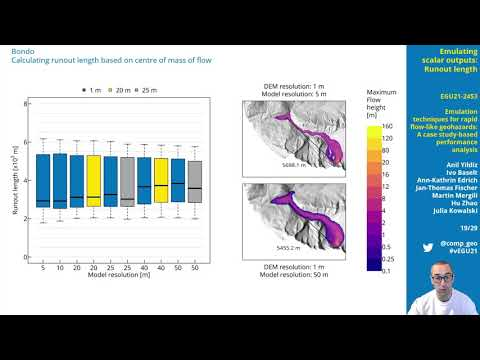

In [3]:
import IPython.display as display
display.YouTubeVideo(id = 'BLdE9f5XOVM', width = 560, height = 315)

We wil use the borehole function, which models the water flow through a borehole, to generate output data, i.e. water flow rate in m<sup>3</sup>/year.

$$
f \left ( x \right ) = \frac{2\pi T_{u}\left ( H_{u} - H_{l} \right )}{\ln{\left (r/r_w  \right )}\left ( 1 + \frac{2LT_u}{\ln{\left (r/r_w  \right )r_{w}^{2}K_w}}+\frac{T_u}{T_l} \right )}
$$

We define the equation as a function named ```borehole_flowrate```

In [4]:
import numpy as np
def borehole_flowrate(r_w, r, t_u, h_u, t_l, h_l, l, k_w):
    nominator = 2 * np.pi * t_u * (h_u - h_l)
    ln_term = np.log(r / r_w)
    term1 = (2 * l * t_u) / (ln_term * (r_w ** 2) * k_w)
    term2 = t_u / t_l
    denominator = ln_term * (1 + term1 + term2)
    result = nominator / denominator
    return(result)   

Input variables and ranges are taken from the [Virtual Library of Simulation Experiments](https://www.sfu.ca/~ssurjano/index.html).

| Parameter | Symbol | Unit | Range |
|----|----|----|----|
| Radius of borehole | r<sub>w</sub> | m | 0.05 - 0.15 |
| Radius of influence | r | m | 100 - 50000 |
| Transmissivity of upper aquifer | T<sub>u</sub> | m<sup>2</sup>/year | 63070 - 115600 |
| Potentiometric head of upper aquifer | H<sub>u</sub> | m | 990 - 1110 |
| Transmissivity of lower aquifer | T<sub>l</sub> | m<sup>2</sup>/year | 63.1 - 116 |
| Potentiometric head of lower aquifer | H<sub>l</sub> | m | 700 - 820 |
| Length of borehole | L | m | 1120 - 1680 |
| Hydraulic conductivity of borehole | K<sub>w</sub> | m<sup></sup>/year | 9855 - 12045 |

For the sake of simplicity, we assume that all parameters are uniformly distributed within their own ranges.

In [5]:
import numpy as np
import pandas as pd
def borehole_input(number_of_runs):
    radius_borehole = np.random.uniform(low = 0.05, high = 0.15, size = number_of_runs)
    radius_influence = np.random.uniform(low = 100, high = 50000, size = number_of_runs)
    trans_upper = np.random.uniform(low = 63070, high = 115600, size = number_of_runs)
    pot_upper = np.random.uniform(low = 990, high = 1110, size = number_of_runs)
    trans_lower = np.random.uniform(low = 63.1, high = 116, size = number_of_runs)
    pot_lower = np.random.uniform(low = 700, high = 820, size = number_of_runs)
    length_borehole = np.random.uniform(low = 1120, high = 1680, size = number_of_runs)
    cond_borehole = np.random.uniform(low = 9855, high = 12045, size = number_of_runs)
    data = np.stack((radius_borehole, radius_influence, trans_upper,
              pot_upper, trans_lower, pot_lower,
              length_borehole, cond_borehole),axis = 1)
    return(data)
input = borehole_input(50)

We will have a look at the [RobustGaSP](https://cran.r-project.org/web/packages/RobustGaSP/RobustGaSP.pdf) package in R maintained by [Mengyang Gu](https://www.pstat.ucsb.edu/people/mengyang-gu) on how to perform predictions.

In [6]:
import importlib.util
if importlib.util.find_spec('rpy2') is None:
    %pip install rpy2 
else:
     import rpy2

In [7]:
import rpy2.robjects.packages as rpackages
base = rpackages.importr('base')
utils = rpackages.importr('utils')
if 'TRUE' not in str(base.require('RobustGaSP')):
    utils.install_packages('RobustGaSP')
else:
    robustgasp = rpackages.importr('RobustGaSP')
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()

In [8]:
output = borehole_flowrate(r_w = input[:, 0], r = input[:, 1], t_u = input[:, 2], h_u = input[:, 3],t_l = input[:, 4], h_l = input[:, 5],l = input[:, 6], k_w = input[:, 7])

We can build a model with the input parametes as ```design``` and output as ```response```. We use the ```rgasp``` function for this.

In [9]:
model = robustgasp.rgasp(design = input, response = output, lower_bound = False)

The upper bounds of the range parameters are Inf Inf Inf Inf Inf Inf Inf Inf 
The initial values of range parameters are 0.0009859955 0.01999988 0.01999989 0.01994758 0.0198781 0.01995023 0.01998913 0.0199973 
Start of the optimization  1  : 
The number of iterations is  28 
 The value of the  marginal posterior  function is  -346.1288 
 Optimized range parameters are 7.590249e+126 Inf Inf Inf Inf Inf Inf Inf 
 Optimized nugget parameter is 0 
 Convergence:  FALSE 
The initial values of range parameters are 0.5753875 287822.6 308442.7 659.8823 283.2773 695.1108 3185.462 12822.76 
Start of the optimization  2  : 
The number of iterations is  67 
 The value of the  marginal posterior  function is  -132.5406 
 Optimized range parameters are 0.2340954 4.261016e+17 9.546212e+20 1178.83 2.440759e+14 1478.246 3829.683 30566.2 
 Optimized nugget parameter is 0 
 Convergence:  FALSE 


We can perform a prediction with the ```leave_one_out_rgasp``` function:

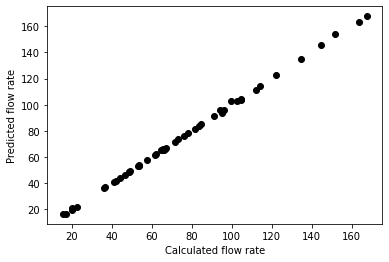

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
predicted = np.array(robustgasp.leave_one_out_rgasp(model))
plt.plot(output,predicted[0,:], 'o', color = 'black')
plt.xlabel('Calculated flow rate')
plt.ylabel('Predicted flow rate')
plt.show()